In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
import plotly.io as pio
import plotly.graph_objects as go
import glob
import os
import re
from itertools import chain
from plots import plot_game_play_id
from distances import calc_dist
from shapely import geometry
from sklearn.preprocessing import StandardScaler
from shapely.ops import unary_union
from shapely.validation import make_valid
from shapely.errors import ShapelyDeprecationWarning
from PIL import Image

In [2]:
pio.renderers.default = 'jupyterlab'
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [3]:
GAMES_PATH='./data/games.csv'
PFF_SCOUTING_DATA_PATH='./data/pffScoutingdata.csv'
PLAYERS_PATH='./data/players.csv'
PLAYS_PATH='./data/plays.csv'
WEEK_PATH='./data/week{}.csv'
WEEK_IDS = [1,2,3,4]
PASS_RESULTS = ['I','C','IN']
SNAP_EVENTS = ['ball_snap', 'autoevent_ballsnap']
NONSNAP_EVENTS = ['autoevent_passforward', 'pass_forward', 'qb_sack', 'autoevent_passinterrupted',
                  'pass_tipped', 'qb_strip_sack', 'autoevent_passinterrupted']
OLINE_POS_lINEDUP= ['C','LT','LG','RT','RG']

In [4]:
def ccworder(A):
    A= A- np.mean(A, 1)[:, None]
    return np.argsort(np.arctan2(A[1, :], A[0, :]))

def gen_snap_df(week_df, snap_events=SNAP_EVENTS):
    snap_df = (week_df
               .query('event.isin(@snap_events)')
               .groupby(['gameId','playId'])
               [['frameId', 'time']].min()
               .reset_index()
               .rename({'frameId': 'snap_frameId',
                        'time': 'snap_time'}, axis=1))
    return snap_df

def gen_nonsnap_df(week_df, nonsnap_events=NONSNAP_EVENTS):
    nonsnap_df = (week_df
               .query('event.isin(@nonsnap_events)')
               .groupby(['gameId','playId'])
               [['frameId','time']].min()
               .reset_index()
               .rename({'frameId': 'nonsnap_frameId',
                        'time': 'nonsnap_time'},axis=1))
    return nonsnap_df

def gen_passer_df(week_df):
    passer_df = (week_df.query('pff_role == "Pass"')
                 [['gameId', 'playId','frameId','time', 'x', 'y', 's','a','dis','o','dir']]
                 .rename({'x': 'qb_x',
                          'y': 'qb_y',
                          's': 'qb_s',
                          'a': 'qb_a',
                          'o': 'qb_o',
                          'dis': 'qb_dis',
                          'dir': 'qb_dir'}, axis=1))
    return passer_df

def gen_line_df(week_df, position, id_cols = ['gameId','nflId', 'playId','frameId'], feats_cols = ['x', 'y', 's','a','dis','o','dir'], oline_pos_lineup=OLINE_POS_lINEDUP, lookback_pd=5, min_speed=0.01, t=0.5):
    
    all_cols = list(chain(*[id_cols, feats_cols]))
    
    rename_cols = {}
    for f in feats_cols:
        renamed_col = f'{position}_{f}'
        rename_cols[f] = renamed_col
    
    if position == 'pb':
        line_df = (week_df
                    .query('pff_role == "Pass Block"'))
                    
        if oline_pos_lineup:
            line_df = (line_df.query('pff_positionLinedUp.isin(@oline_pos_lineup)'))
    else:
        line_df = (week_df
                    .query('pff_role == "Pass Rush"'))
    
    line_df = (line_df[all_cols].rename(rename_cols, axis=1))
    
    line_id_df = line_df[['gameId','playId','nflId']].drop_duplicates().groupby(['gameId', 'playId']).apply(lambda x: x.reset_index(drop=True).reset_index()).reset_index(drop=True).rename({'index': f'{position}_id'}, axis=1)

    line_df = (line_df.merge(line_id_df, how='left', on=['gameId', 'playId', 'nflId']))
    line_df[f'{position}_displacement'] = line_df.apply(lambda x: max(x[f'{position}_s'], min_speed) * t + 0.5*(x[f'{position}_a']) * t**2, axis=1)
    line_df[f'{position}_point'] = line_df.apply(lambda x: geometry.Point(x[f'{position}_x'], x[f'{position}_y']).buffer(x[f'{position}_displacement']), axis=1)
    
#     all_movement_paths = []
#     for k, df_grp in line_df.groupby(['gameId', 'playId', 'nflId']):
        
#         all_paths = []
#         for i in range(1, len(df_grp)+1):
#             all_paths.append(unary_union(df_grp[f'{position}_point'].values[max(0, i - lookback_pd):i]))
        
#         df_grp[f'{position}_movement_path'] = all_paths
#         all_movement_paths.append(df_grp)
#     line_df_poly = pd.concat(all_movement_paths)
    return line_id_df, line_df

def pivot_line_df(line_df, position):
    line_df = line_df.pivot(index=['gameId', 'playId', 'frameId'], columns=[f'{position}_id'], values=[f'{position}_point', f'{position}_x', f'{position}_y', f'{position}_o', f'{position}_dir', f'{position}_s', f'{position}_a', f'{position}_dis'])
    line_df.columns = ['{}_{}'.format(c[0], c[1]) for c in line_df.columns]
    line_df.reset_index(inplace=True)
    return line_df

def gen_pocket_polygon(row):
    
    # row = pocket_area_df.iloc[0]
    
    all_coords = []
    for c in row.index.values:
        
        if 'pb_x' in c:
            if not(pd.isnull(row[c])):
                all_coords.append((row[c], row[c.replace('_x', '_y')]))
    
    all_coords2 = np.array(all_coords)[np.argsort(np.array(all_coords)[:,1])]
    oline_coords2 = np.vstack([all_coords2,[row['qb_x'], row['qb_y']]])
    
    all_coords.append((row['qb_x'], row['qb_y']))
    
    A = np.array(all_coords).T
    sorted_order = ccworder(A)
    oline_coords = A.T[sorted_order]
    
    geom1 = geometry.Polygon(oline_coords)
    geom2 = geometry.Polygon(oline_coords2)
    
    if geom1.area > geom2.area:
        return geom1
    else:
        return geom2
    
def gen_pocket_area_df(passer_df, pass_blockers_df, snap_df, nonsnap_df):
    
    pass_blockers_df = pivot_line_df(pass_blockers_df, position='pb')
    
    pocket_area_df = (passer_df
                          .merge(pass_blockers_df, how='left', on=['gameId', 'playId', 'frameId'])
                          .merge(snap_df, how='left', on=['gameId', 'playId'])
                          .merge(nonsnap_df, how='left', on=['gameId', 'playId'])
                          .query('(frameId >= snap_frameId) & (frameId <= nonsnap_frameId)')
                          .assign(
                              time_since_snap = lambda x: (pd.to_datetime(x['time']) - pd.to_datetime(x['snap_time'])).dt.total_seconds()
                              ))
    
    pocket_area_df['pocket_polygon'] = pocket_area_df.apply(lambda x: gen_pocket_polygon(x), axis=1)
    pocket_area_df['pocket_area'] = pocket_area_df['pocket_polygon'].apply(lambda x: x.area)
    return pocket_area_df

# def gen_pocket_adj_risk_poly(row):
#     pocket_poly = row['pocket_polygon']
#     pocket_poly = make_valid(pocket_poly)
    
#     pb_paths = [p for p in row.index.values if 'pb_point' in p]
#     pr_paths = [p for p in row.index.values if 'pr_point' in p]
    
#     pb_paths_poly = [p for p in row[pb_paths].values if not(pd.isnull(p))]
#     pr_paths_poly = [p for p in row[pr_paths].values if not(pd.isnull(p))]
    
#     pr_combined = unary_union(pr_paths_poly)
#     pb_combined = unary_union(pb_paths_poly)
    
#     attack_polys = (pr_combined.symmetric_difference(pb_combined)).difference(pb_combined)
#     attack_polys = make_valid(attack_polys)
    
#     attack_in_pocket_poly = pocket_poly.intersection(attack_polys)
    
#     return attack_in_pocket_poly

def gen_pocket_adj_risk_poly(row):
    pocket_poly = row['pocket_polygon']
    pocket_poly = make_valid(pocket_poly)
    
    # pb_paths = [p for p in row.index.values if 'pb_point' in p]
    pr_paths = [p for p in row.index.values if 'pr_point' in p]
    
    # pb_paths_poly = [p for p in row[pb_paths].values if not(pd.isnull(p))]
    pr_paths_poly = [p for p in row[pr_paths].values if not(pd.isnull(p))]
    
    pr_combined = unary_union(pr_paths_poly)
    # pb_combined = unary_union(pb_paths_poly)
    
    # attack_polys = (pr_combined.symmetric_difference(pb_combined)).difference(pb_combined)
    attack_polys = make_valid(pr_combined)
    
    # attack_in_pocket_poly = pocket_poly.intersection(attack_polys)
    
    return attack_polys

def make_gif(frame_folder, fname):
    all_fnames = glob.glob(f"{frame_folder}/*.png")
    l = sorted(all_fnames, key=get_key)
    frames = [Image.open(image) for image in l]
    frame_one = frames[0]
    frame_one.save(fname, format="GIF", append_images=frames, save_all=True, duration=200, loop=0)
    
def get_key(fp):
    filename = os.path.splitext(os.path.basename(fp))[0]
    int_part = filename[filename.find("(")+1:filename.find(")")]
    return int(int_part)

# 1. Load Data

In [5]:
games_df = pd.read_csv(GAMES_PATH)
plays_df = pd.read_csv(PLAYS_PATH)
players_df = pd.read_csv(PLAYERS_PATH)
pff_scouting_df = pd.read_csv(PFF_SCOUTING_DATA_PATH)

games_df = games_df.query('week.isin(@WEEK_IDS)')
plays_df = plays_df.merge(games_df, how='inner', on=['gameId'])
pff_scouting_df = pff_scouting_df.merge(games_df['gameId'], how='inner', on='gameId', validate='m:1')

In [6]:
#Filter for pass plays only
plays_df = (plays_df
            .query('(pff_playAction == 0) & (passResult.isin(@PASS_RESULTS))')
            .query('foulName1.isna()')
            .query('dropBackType == "TRADITIONAL"'))

#Load the weekly data
week_df = []
for week_id in WEEK_IDS:
    week_df.append(pd.read_csv(WEEK_PATH.format(week_id)))
week_df = pd.concat(week_df)

week_df = (week_df
           .merge(players_df, how='left', on='nflId', validate='m:1')
           .merge(pff_scouting_df, how='left', on=['nflId', 'gameId', 'playId'], validate='m:1')
           .merge(plays_df, how='inner', on=['gameId', 'playId'], validate='m:1')
           )

#Generate the snap event dataframe
snap_df = gen_snap_df(week_df)
nonsnap_df = gen_nonsnap_df(week_df)

#Get the QB dataframe
passer_df = gen_passer_df(week_df)

#Get the pass blockers dataframe
pass_blockers_id_df, pass_blockers_poly_df = gen_line_df(week_df, position='pb')
all_pass_blockers_id_df, all_pass_blockers_poly_df = gen_line_df(week_df, position='pb', oline_pos_lineup=None)
pass_rushers_id_df, pass_rushers_poly_df = gen_line_df(week_df, position='pr')

# 2. Pocket Area Generation

In [7]:
pocket_area_df = gen_pocket_area_df(passer_df, pass_blockers_poly_df, snap_df, nonsnap_df)
pocket_area_df = pocket_area_df.drop([c for c in pocket_area_df.columns if 'pb_' in c], axis=1)
pocket_area_df = pocket_area_df.merge(pivot_line_df(all_pass_blockers_poly_df, 'pb'), how='left', on=['gameId', 'playId', 'frameId'])

pb_movement_cols = [c for c in pocket_area_df.columns if 'pb_point_' in c]
all_cols = list(chain(*[['gameId', 'playId', 'frameId', 'time', 'time_since_snap','snap_frameId','nonsnap_frameId', 'pocket_polygon', 'pocket_area'], pb_movement_cols]))

pocket_area_df = pocket_area_df[all_cols]

In [8]:
pocket_area_df.head()

,gameId,playId,frameId,time,time_since_snap,snap_frameId,nonsnap_frameId,pocket_polygon,pocket_area,pb_point_0,pb_point_1,pb_point_2,pb_point_3,pb_point_4,pb_point_5,pb_point_6,pb_point_7,pb_point_8
0,2021090900,97,6,2021-09-10T00:26:31.600,0.0,6.0,38.0,"POLYGON ((41.11 21.31, 41.41 22.63, 42.1 24.02...",12.63610,"POLYGON ((42.6025 24.02, 42.60008032515278 23....","POLYGON ((42.167500000000004 26.92, 42.1637079...","POLYGON ((41.95375 25.65, 41.953635637258465 2...","POLYGON ((41.491249999999994 22.63, 41.4908587...","POLYGON ((41.43125 21.31, 41.42970309344344 21...",NaN,NaN,NaN,NaN
1,2021090900,97,7,2021-09-10T00:26:31.700,0.1,6.0,38.0,"POLYGON ((41.07 21.27, 41.4 22.64, 42.03 24.06...",12.95585,"POLYGON ((42.691250000000004 24.06, 42.6880659...","POLYGON ((42.21 26.95, 42.20552179580515 26.85...","POLYGON ((42.158750000000005 25.65, 42.1576003...","POLYGON ((41.625 22.64, 41.62391656350124 22.6...","POLYGON ((41.54625 21.27, 41.54395672607763 21...",NaN,NaN,NaN,NaN
2,2021090900,97,8,2021-09-10T00:26:31.800,0.2,6.0,38.0,"POLYGON ((40.99 21.21, 41.37 22.66, 41.95 24.1...",13.39680,"POLYGON ((42.68 24.1, 42.67648485047071 24.028...","POLYGON ((42.1775 27.01, 42.172504153922404 26...","POLYGON ((42.35 25.65, 42.34778497426921 25.60...","POLYGON ((41.769999999999996 22.66, 41.7680738...","POLYGON ((41.66875 21.21, 41.66548163322876 21...",NaN,NaN,NaN,NaN
3,2021090900,97,9,2021-09-10T00:26:31.900,0.3,6.0,38.0,"POLYGON ((40.87 21.14, 41.32 22.68, 41.86 24.1...",13.94870,"POLYGON ((42.613749999999996 24.16, 42.6101204...","POLYGON ((42.224999999999994 27.11, 42.2188123...","POLYGON ((42.44375 25.65, 42.440842778728346 2...","POLYGON ((41.8325 22.68, 41.8300321724195 22.6...","POLYGON ((41.762499999999996 21.14, 41.7582023...",NaN,NaN,NaN,NaN
4,2021090900,97,10,2021-09-10T00:26:32.000,0.4,6.0,38.0,"POLYGON ((40.75 21.05, 41.25 22.69, 41.74 24.2...",14.44050,"POLYGON ((42.57125 24.24, 42.56724730404627 24...","POLYGON ((42.10125 27.2, 42.09459890371597 27....","POLYGON ((42.553749999999994 25.66, 42.5497834...","POLYGON ((41.79125 22.69, 41.788643733311325 2...","POLYGON ((41.675 21.05, 41.67054587217178 20.9...",NaN,NaN,NaN,NaN


# 3. Pass Rusher Influence

In [9]:
pass_rushers_poly_df.head()

,gameId,nflId,playId,frameId,pr_x,pr_y,pr_s,pr_a,pr_dis,pr_o,pr_dir,pr_id,pr_displacement,pr_point
0,2021090900,41263.0,97,1,43.66,18.70,0.45,0.92,0.05,308.77,337.59,0,0.34000,"POLYGON ((44 18.7, 43.998362807068546 18.66667..."
1,2021090900,41263.0,97,2,43.62,18.75,0.57,0.73,0.06,308.77,331.21,0,0.37625,"POLYGON ((43.996249999999996 18.75, 43.9944382..."
2,2021090900,41263.0,97,3,43.59,18.80,0.63,0.48,0.06,308.77,331.38,0,0.37500,"POLYGON ((43.965 18.8, 43.96319427250208 18.76..."
3,2021090900,41263.0,97,4,43.52,18.83,0.67,0.39,0.08,318.19,316.36,0,0.38375,"POLYGON ((43.90375 18.83, 43.90190213886046 18..."
4,2021090900,41263.0,97,5,43.41,18.87,0.85,1.00,0.12,311.63,298.40,0,0.55000,"POLYGON ((43.959999999999994 18.87, 43.9573515..."


In [10]:
pocket_area_df.head()

,gameId,playId,frameId,time,time_since_snap,snap_frameId,nonsnap_frameId,pocket_polygon,pocket_area,pb_point_0,pb_point_1,pb_point_2,pb_point_3,pb_point_4,pb_point_5,pb_point_6,pb_point_7,pb_point_8
0,2021090900,97,6,2021-09-10T00:26:31.600,0.0,6.0,38.0,"POLYGON ((41.11 21.31, 41.41 22.63, 42.1 24.02...",12.63610,"POLYGON ((42.6025 24.02, 42.60008032515278 23....","POLYGON ((42.167500000000004 26.92, 42.1637079...","POLYGON ((41.95375 25.65, 41.953635637258465 2...","POLYGON ((41.491249999999994 22.63, 41.4908587...","POLYGON ((41.43125 21.31, 41.42970309344344 21...",NaN,NaN,NaN,NaN
1,2021090900,97,7,2021-09-10T00:26:31.700,0.1,6.0,38.0,"POLYGON ((41.07 21.27, 41.4 22.64, 42.03 24.06...",12.95585,"POLYGON ((42.691250000000004 24.06, 42.6880659...","POLYGON ((42.21 26.95, 42.20552179580515 26.85...","POLYGON ((42.158750000000005 25.65, 42.1576003...","POLYGON ((41.625 22.64, 41.62391656350124 22.6...","POLYGON ((41.54625 21.27, 41.54395672607763 21...",NaN,NaN,NaN,NaN
2,2021090900,97,8,2021-09-10T00:26:31.800,0.2,6.0,38.0,"POLYGON ((40.99 21.21, 41.37 22.66, 41.95 24.1...",13.39680,"POLYGON ((42.68 24.1, 42.67648485047071 24.028...","POLYGON ((42.1775 27.01, 42.172504153922404 26...","POLYGON ((42.35 25.65, 42.34778497426921 25.60...","POLYGON ((41.769999999999996 22.66, 41.7680738...","POLYGON ((41.66875 21.21, 41.66548163322876 21...",NaN,NaN,NaN,NaN
3,2021090900,97,9,2021-09-10T00:26:31.900,0.3,6.0,38.0,"POLYGON ((40.87 21.14, 41.32 22.68, 41.86 24.1...",13.94870,"POLYGON ((42.613749999999996 24.16, 42.6101204...","POLYGON ((42.224999999999994 27.11, 42.2188123...","POLYGON ((42.44375 25.65, 42.440842778728346 2...","POLYGON ((41.8325 22.68, 41.8300321724195 22.6...","POLYGON ((41.762499999999996 21.14, 41.7582023...",NaN,NaN,NaN,NaN
4,2021090900,97,10,2021-09-10T00:26:32.000,0.4,6.0,38.0,"POLYGON ((40.75 21.05, 41.25 22.69, 41.74 24.2...",14.44050,"POLYGON ((42.57125 24.24, 42.56724730404627 24...","POLYGON ((42.10125 27.2, 42.09459890371597 27....","POLYGON ((42.553749999999994 25.66, 42.5497834...","POLYGON ((41.79125 22.69, 41.788643733311325 2...","POLYGON ((41.675 21.05, 41.67054587217178 20.9...",NaN,NaN,NaN,NaN


# Presentation

### Pocket Area

In [ ]:
week_df_append_polygon = pocket_area_df[['gameId', 'playId', 'frameId', 'pocket_polygon']]
week_df_append_polygon['team'] = 'pocket_polygon'
pocket_area_appended = pd.concat([week_df, week_df_append_polygon], axis=0)
all_gameplays_df = pocket_area_appended[['gameId', 'playId']].drop_duplicates().reset_index(drop=True)

idx = 0
gameId = all_gameplays_df['gameId'].values[idx]
playId = all_gameplays_df['playId'].values[idx]
plot_game_play_id(pocket_area_appended, gameId, playId, size=(1200, 800))
pocket_area_df_subset = pocket_area_df.query('(gameId == @gameId) & (playId == @playId)')
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.lineplot(x=pocket_area_df_subset['frameId'], y=pocket_area_df_subset['pocket_area'], linewidth=2.5, ax=ax, marker='o', alpha=0.5)
ax.set_ylabel(r"Pocket Area $(yds^{2})$", size=10)
ax.set_xlabel('Frame ID', size=10)
ax.set_title(f'GameID: {gameId}\nPlayID: {playId}', size=11)
ax.grid()
ax.annotate('Ball Snapped',
            xy=(pocket_area_df_subset['frameId'].values[0], pocket_area_df_subset['pocket_area'].values[0]), xycoords='data',
            xytext=(-15, -20), textcoords='offset points', size=8)
ax.annotate('Ball Thrown',
            xy=(pocket_area_df_subset['frameId'].values[-1], pocket_area_df_subset['pocket_area'].values[-1]), xycoords='data',
            xytext=(-15, 10), textcoords='offset points', size=8)
ax.annotate('Pocket Starts Collapsing',
            xy=(pocket_area_df_subset['frameId'].values[12], pocket_area_df_subset['pocket_area'].values[12]), xycoords='data',
            xytext=(0, 5), textcoords='offset points', size=8)
plt.savefig('./images/pocketarea.png', dpi='figure')
plt.show()

### Pass Rushers

In [18]:
pass_rushers_append_polygon

,gameId,playId,frameId,player_polygon,team
0,2021090900,97,1,"POLYGON ((44 18.7, 43.998362807068546 18.66667...",player_polygon
1,2021090900,97,2,"POLYGON ((43.996249999999996 18.75, 43.9944382...",player_polygon
2,2021090900,97,3,"POLYGON ((43.965 18.8, 43.96319427250208 18.76...",player_polygon
3,2021090900,97,4,"POLYGON ((43.90375 18.83, 43.90190213886046 18...",player_polygon
4,2021090900,97,5,"POLYGON ((43.959999999999994 18.87, 43.9573515...",player_polygon
...,...,...,...,...,...
403562,2021100400,4161,46,"POLYGON ((15.61125 20.61, 15.605032278315475 2...",player_polygon
403563,2021100400,4161,47,"POLYGON ((15.8 20.45, 15.793595686474022 20.31...",player_polygon
403564,2021100400,4161,48,"POLYGON ((15.977500000000001 20.31, 15.9710114...",player_polygon
403565,2021100400,4161,49,"POLYGON ((16.22125 20.16, 16.214550750982696 2...",player_polygon


In [40]:
week_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,6-4,225.0,1977-08-03,Michigan,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,6-4,225.0,1977-08-03,Michigan,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,2021,1,09/09/2021,20:20:00,TB,DAL
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,6-4,225.0,1977-08-03,Michigan,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,2021,1,09/09/2021,20:20:00,TB,DAL
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,6-4,225.0,1977-08-03,Michigan,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,2021,1,09/09/2021,20:20:00,TB,DAL
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,6-4,225.0,1977-08-03,Michigan,QB,Tom Brady,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,2021,1,09/09/2021,20:20:00,TB,DAL


E:\kaggle\nfl-big-data-bowl-2023\plots.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



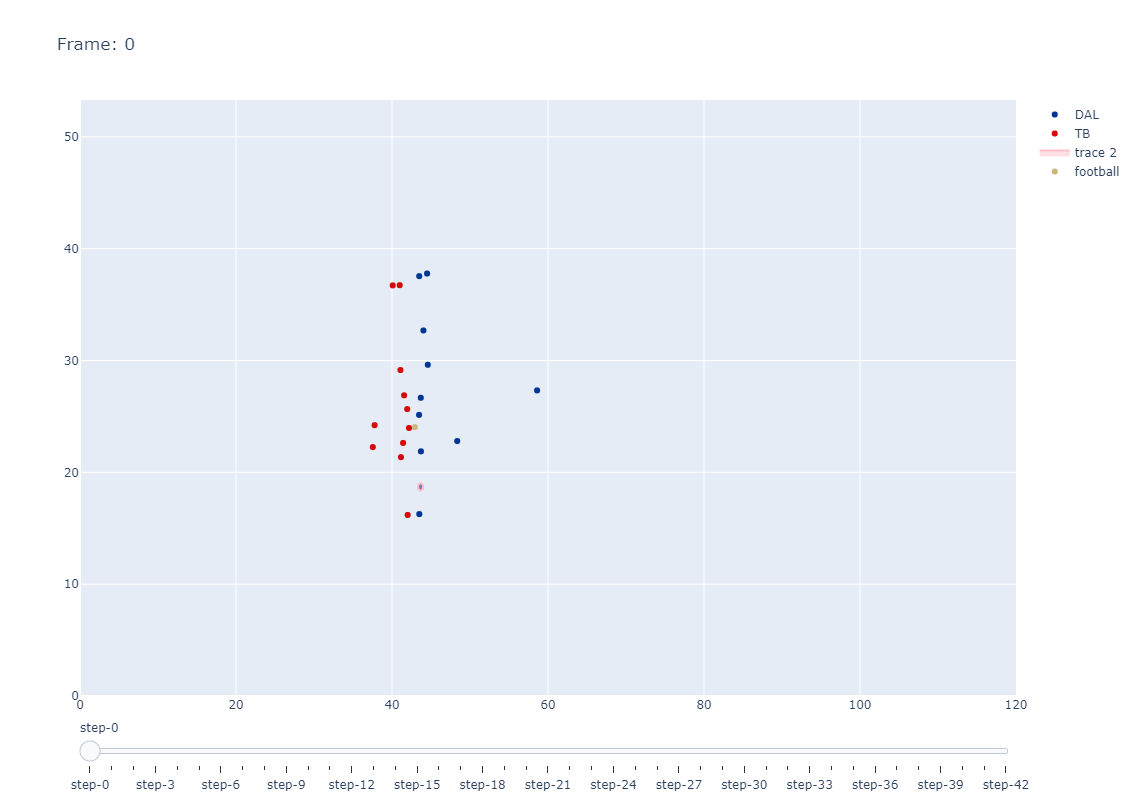

In [44]:
pass_rushers_append_polygon = pass_rushers_poly_df[['gameId', 'playId', 'frameId', 'pr_point']].rename({'pr_point': 'affected_pocket_polygon'}, axis=1)
pass_rushers_append_polygon['team'] = 'affected_pocket_polygon'
pass_rusher_appended = pd.concat([week_df, pass_rushers_append_polygon], axis=0)
all_gameplays_df = pass_rusher_appended[['gameId', 'playId']].drop_duplicates().reset_index(drop=True)
idx = 0
gameId = all_gameplays_df['gameId'].values[idx]
playId = all_gameplays_df['playId'].values[idx]
plot_game_play_id(pass_rusher_appended, gameId, playId, size=(1200, 800))

In [45]:
make_gif('./images/player_polygons', './images/player_polygon.gif')